## Notebook Objectives

Summarize the Necessary Knowleadge to Apply Exploratory Data Analysis


### Agenda

[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Functions](#Functions)<br>
&emsp;[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>

[Feature Engineering](#Feature-Engineering)<br>

[Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
&emsp;[Summary Statistics](#Summary-Statistics)<br>
&emsp;[Missing Values](#Missing-Values)<br>

[Univariate Analysis](#Univariate-Analysis)<br>
&emsp;[Histograms](#Histograms)<br>
&emsp;[Box Plots](#Box-Plots)<br>
&emsp;[Bar Plots](#Bar-Plots)<br>

[Bivariate Analysis](#Bivariate-Analysis)<br>
&emsp;[Scatter Plots](#Scatter-Plots)<br>
&emsp;[Pair Plots](#Pair-Plots)<br>
&emsp;[Box Plots by Category](#Box-Plots-by-Category)<br>

[Multivariate Analysis](#Multivariate-Analysis)<br>
&emsp;[Correlation Heatmap](#Correlation-Heatmap)<br>
&emsp;[3D Scatter Plot](#3D-Scatter-Plot)<br>

[Data Distribution and Density](#Data-Distribution-and-Density)<br>
&emsp;[Denity Plots (KDE)](#Denity-Plots-(KDE))<br>
&emsp;[Hexbin Plots](#Hexbin-Plots)<br>

&emsp;[Summary and Insights](#Summary-and-Insights)<br>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [13]:
def describe_data(data):
    """ Inform Data Dimension. Data Types. Count and % of NaN.

    :param data: pandas.DataFrame
    :return: pandas.DataFrame with columns=['data_types', 'nan_count', 'nan_percentage']
    """

    print(f"Shape: {data.shape}")
    try:
        print(f"Duplicates: {data.duplicated().any()}")
    except Exception as e:
        print(f"Error when searching for duplicates:\n\t{e}")

    is_na = data.isna().sum()
    is_na_percentage = is_na / data.shape[0] * 100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    return nan_data_frame

### Settings

In [3]:
pd.set_option("display.max_columns", None)

### Loading Data

In [4]:
# https://www.kaggle.com/datasets/jr2ngb/superstore-data
df_superstore = pd.read_csv("../data/superstore_dataset2011-2015.csv", encoding = "ISO-8859-1")
print(df_superstore.shape)
df_superstore.head(2)

(51290, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium


## Feature Engineering

In [5]:
df_customer_abt = (
    df_superstore
        .groupby('Customer ID')
        .agg(
            total_sales=('Sales', 'sum'),
            avg_ticket=('Sales', 'mean'),
            total_products=('Quantity', 'sum'),
            avg_produtcs_per_purchase=('Quantity', 'mean'),
            median_discount=('Discount', 'median'),
            avg_discount=('Discount', 'mean'),
            std_discount=('Discount', 'std'),
            total_profit=('Profit', 'sum'),
            avg_profit=('Profit', 'mean'),
            total_shipping_cost=('Shipping Cost', 'sum'),
            avg_shipping_cost=('Shipping Cost', 'mean'),
            segment=('Segment','max'),
            market=('Market', lambda x: x.mode()[0]),
            most_used_ship_mode=('Ship Mode', lambda x: x.mode()[0])
        ).reset_index()
)
print(df_customer_abt.shape)
df_customer_abt.head(2)

(1590, 15)


,Customer ID,total_sales,avg_ticket,total_products,avg_produtcs_per_purchase,median_discount,avg_discount,std_discount,total_profit,avg_profit,total_shipping_cost,avg_shipping_cost,segment,market,most_used_ship_mode
0,AA-10315,13747.413,327.319357,145,3.452381,0.0,0.103571,0.159034,447.6905,10.659298,1236.15,29.432143,Consumer,EU,Standard Class
1,AA-10375,5884.195,140.099881,139,3.309524,0.0,0.166667,0.218271,677.4774,16.130414,903.92,21.521905,Consumer,US,First Class


In [29]:
features = df_customer_abt.select_dtypes('number').columns
categories = df_customer_abt.select_dtypes(object).columns

## Exploratory Data Analysis

### Summary Statistics

We need it to **understand Data Distribution and Dispersion**.    

        Mean, median, and mode reveal central tendencies.
        standard deviation and variance show data spread.
        Skewness and kurtosis help identify asymmetry and tail behavior.

**Detect Outliers**: extreme values can heavily impact clustering results.    

**Feature Scaling and Normalization**: statistics like range and standard deviation guide whether scaling is necessary.

        Features on different scales can dominate the distance calculation, leading to biased clustering results.
        Or, if you identify variable with 0 variance you might decide to remove them from further analysis.

**Sparse Features:** where most of the values are zero (common in high-dimensional datasets). 

        Clusters may form based on the absence of certain attributes (the zeros) rather than the presence of meaningful attributes.
        This can result in clusters that are not meaningful or representative of actual patterns in the data 
        (so they might may not correspond to actual real-world segments).

In [9]:
df_customer_abt[features].describe().T

,count,mean,std,min,25%,50%,75%,max
total_sales,1590.0,7951.259063,6936.570172,7.1730,1674.812250,6248.135590,13133.098420,35668.120800
avg_ticket,1590.0,214.915028,104.991039,7.1730,134.582758,214.507356,277.118073,902.748000
total_products,1590.0,112.145912,90.881731,1.0000,27.000000,77.000000,195.000000,398.000000
avg_produtcs_per_purchase,1590.0,3.031905,0.935294,1.0000,2.222222,3.311422,3.777778,10.000000
median_discount,1590.0,0.074127,0.165924,0.0000,0.000000,0.000000,0.100000,0.700000
avg_discount,1590.0,0.154432,0.109474,0.0000,0.090920,0.136739,0.192385,0.700000
std_discount,1583.0,0.207192,0.093313,0.0000,0.165235,0.202895,0.275003,0.494975
total_profit,1590.0,922.929114,1328.397668,-6437.3681,94.812000,591.357100,1614.486975,8787.474900
avg_profit,1590.0,23.218680,43.825170,-511.7700,7.375106,24.614881,41.807361,334.134000
total_shipping_cost,1590.0,850.830623,748.508224,0.8500,172.617500,660.665000,1393.485000,3593.080000


In [11]:
df_customer_abt[categories].describe().T

,count,unique,top,freq
Customer ID,1590,1590,AA-10315,1
segment,1590,3,Consumer,818
market,1590,7,EMEA,395
most_used_ship_mode,1590,4,Standard Class,1329


### Missing Values

We need to determine the extent and pattern of missing data to decide on appropriate handling methods.

        Remove or Impute (mean, median, machine learning imputation, business knowledge...)

In [14]:
describe_data(df_customer_abt)

Shape: (1590, 15)
Duplicates: False


,data_types,nan_count,nan_percentage
Customer ID,object,0,0.000000
total_sales,float64,0,0.000000
avg_ticket,float64,0,0.000000
total_products,int64,0,0.000000
avg_produtcs_per_purchase,float64,0,0.000000
median_discount,float64,0,0.000000
avg_discount,float64,0,0.000000
std_discount,float64,7,0.440252
total_profit,float64,0,0.000000
avg_profit,float64,0,0.000000


### Univariate Analysis

Visualize the frequency distribution of continuous variables. Identify skewness and outliers.

Skewed distributions can lead to biased clustering results, as the algorithm may be more influenced by the the extreme values rather than the majority of the data (it might require normalization)

Multimodal distributions can suggest the presence of natural subgroups within the data.

Outliers can significantly affect the centroids and boundaries of clusters. Clusters might be larger of smaller tant they should be, or certain clusters may contain outliers that do not represent their general characteristics.

#### Histograms

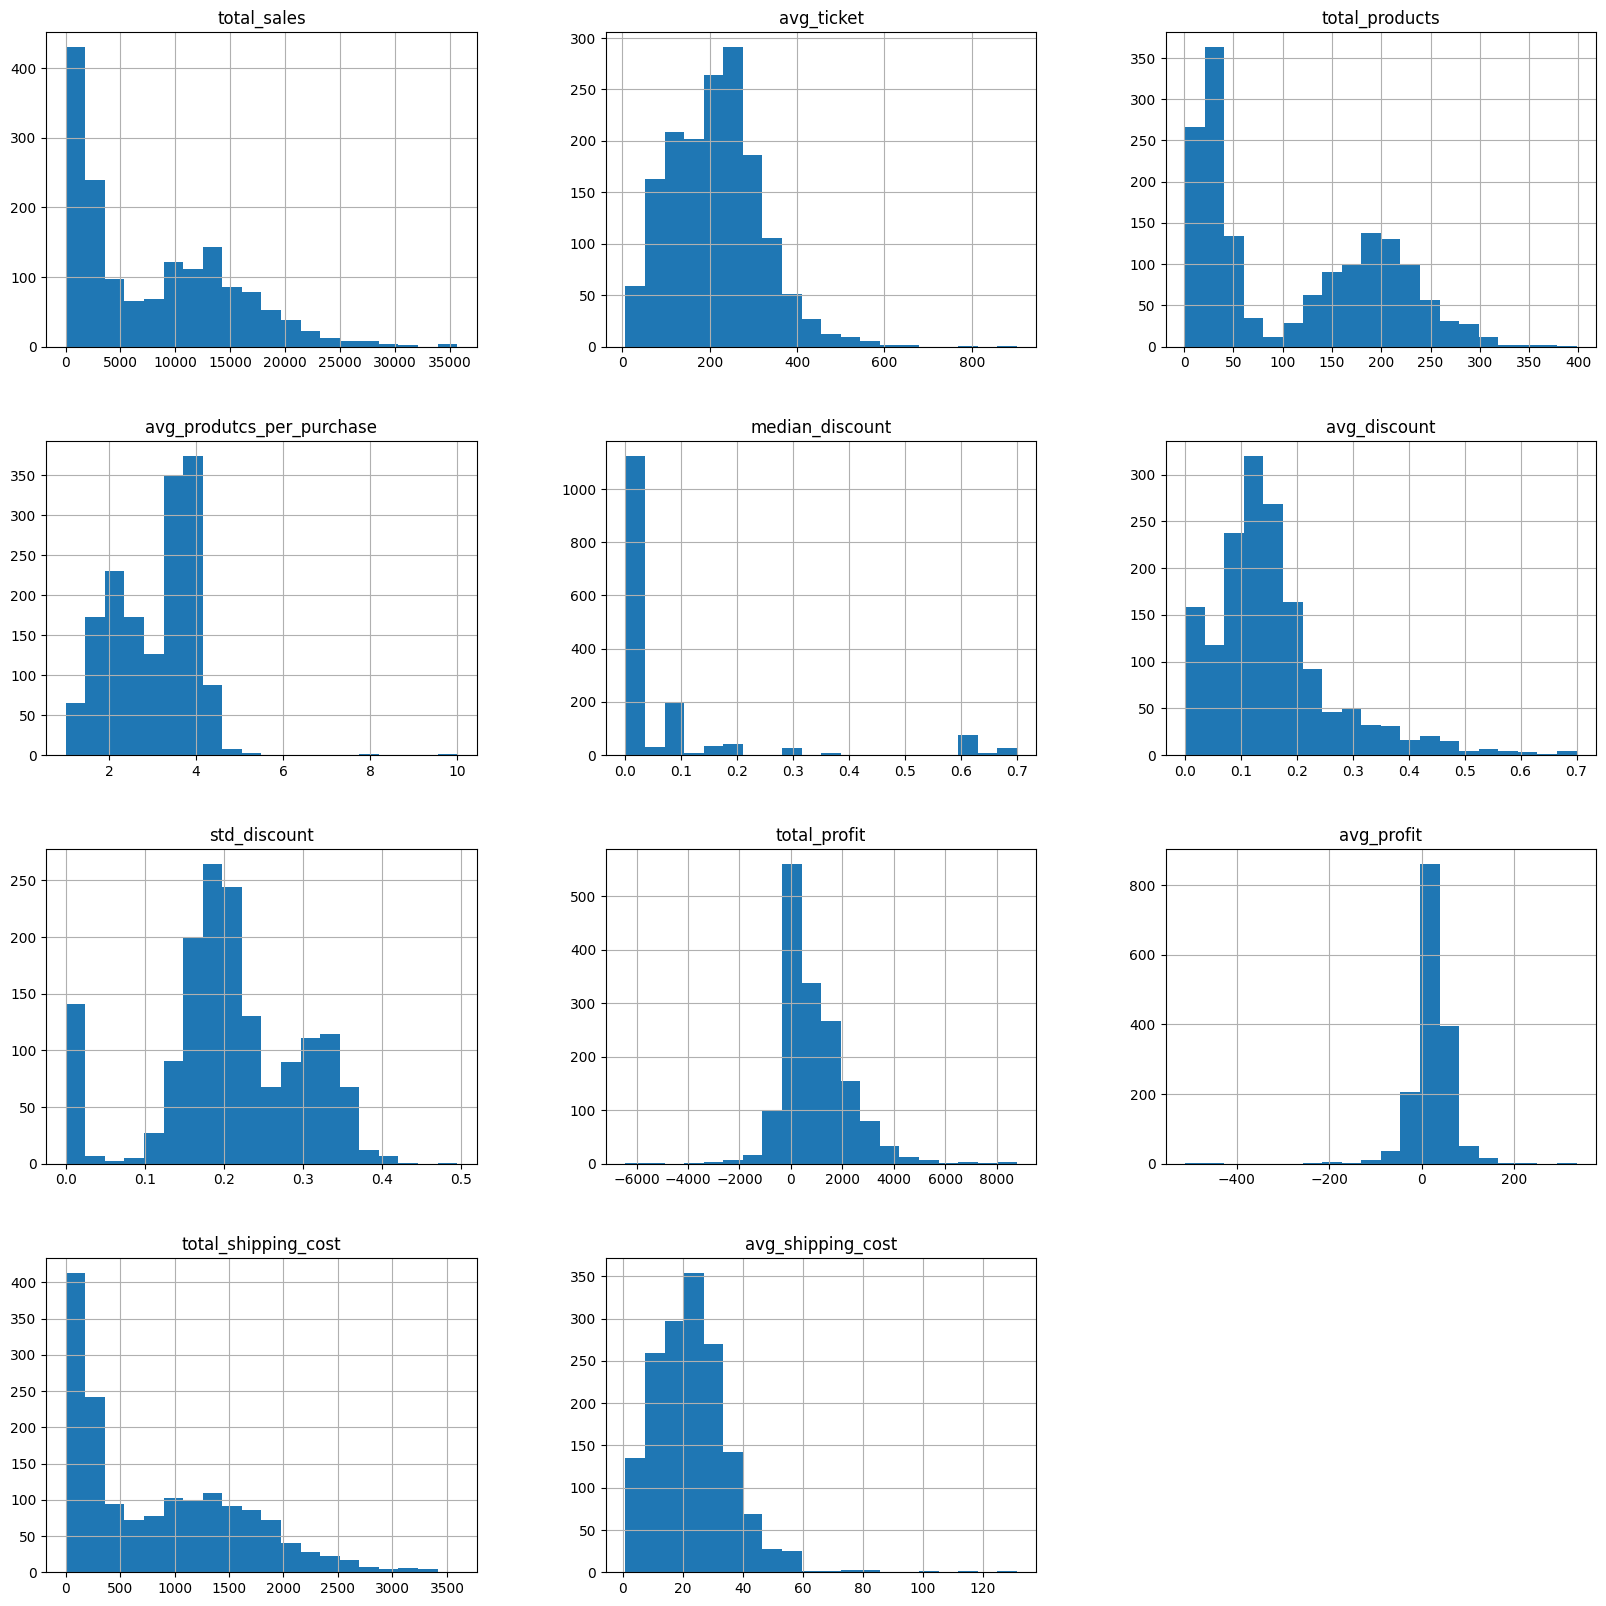

In [32]:
df_customer_abt[features].hist(bins=20, figsize=(20, 20))
plt.show()

#### Box Plots

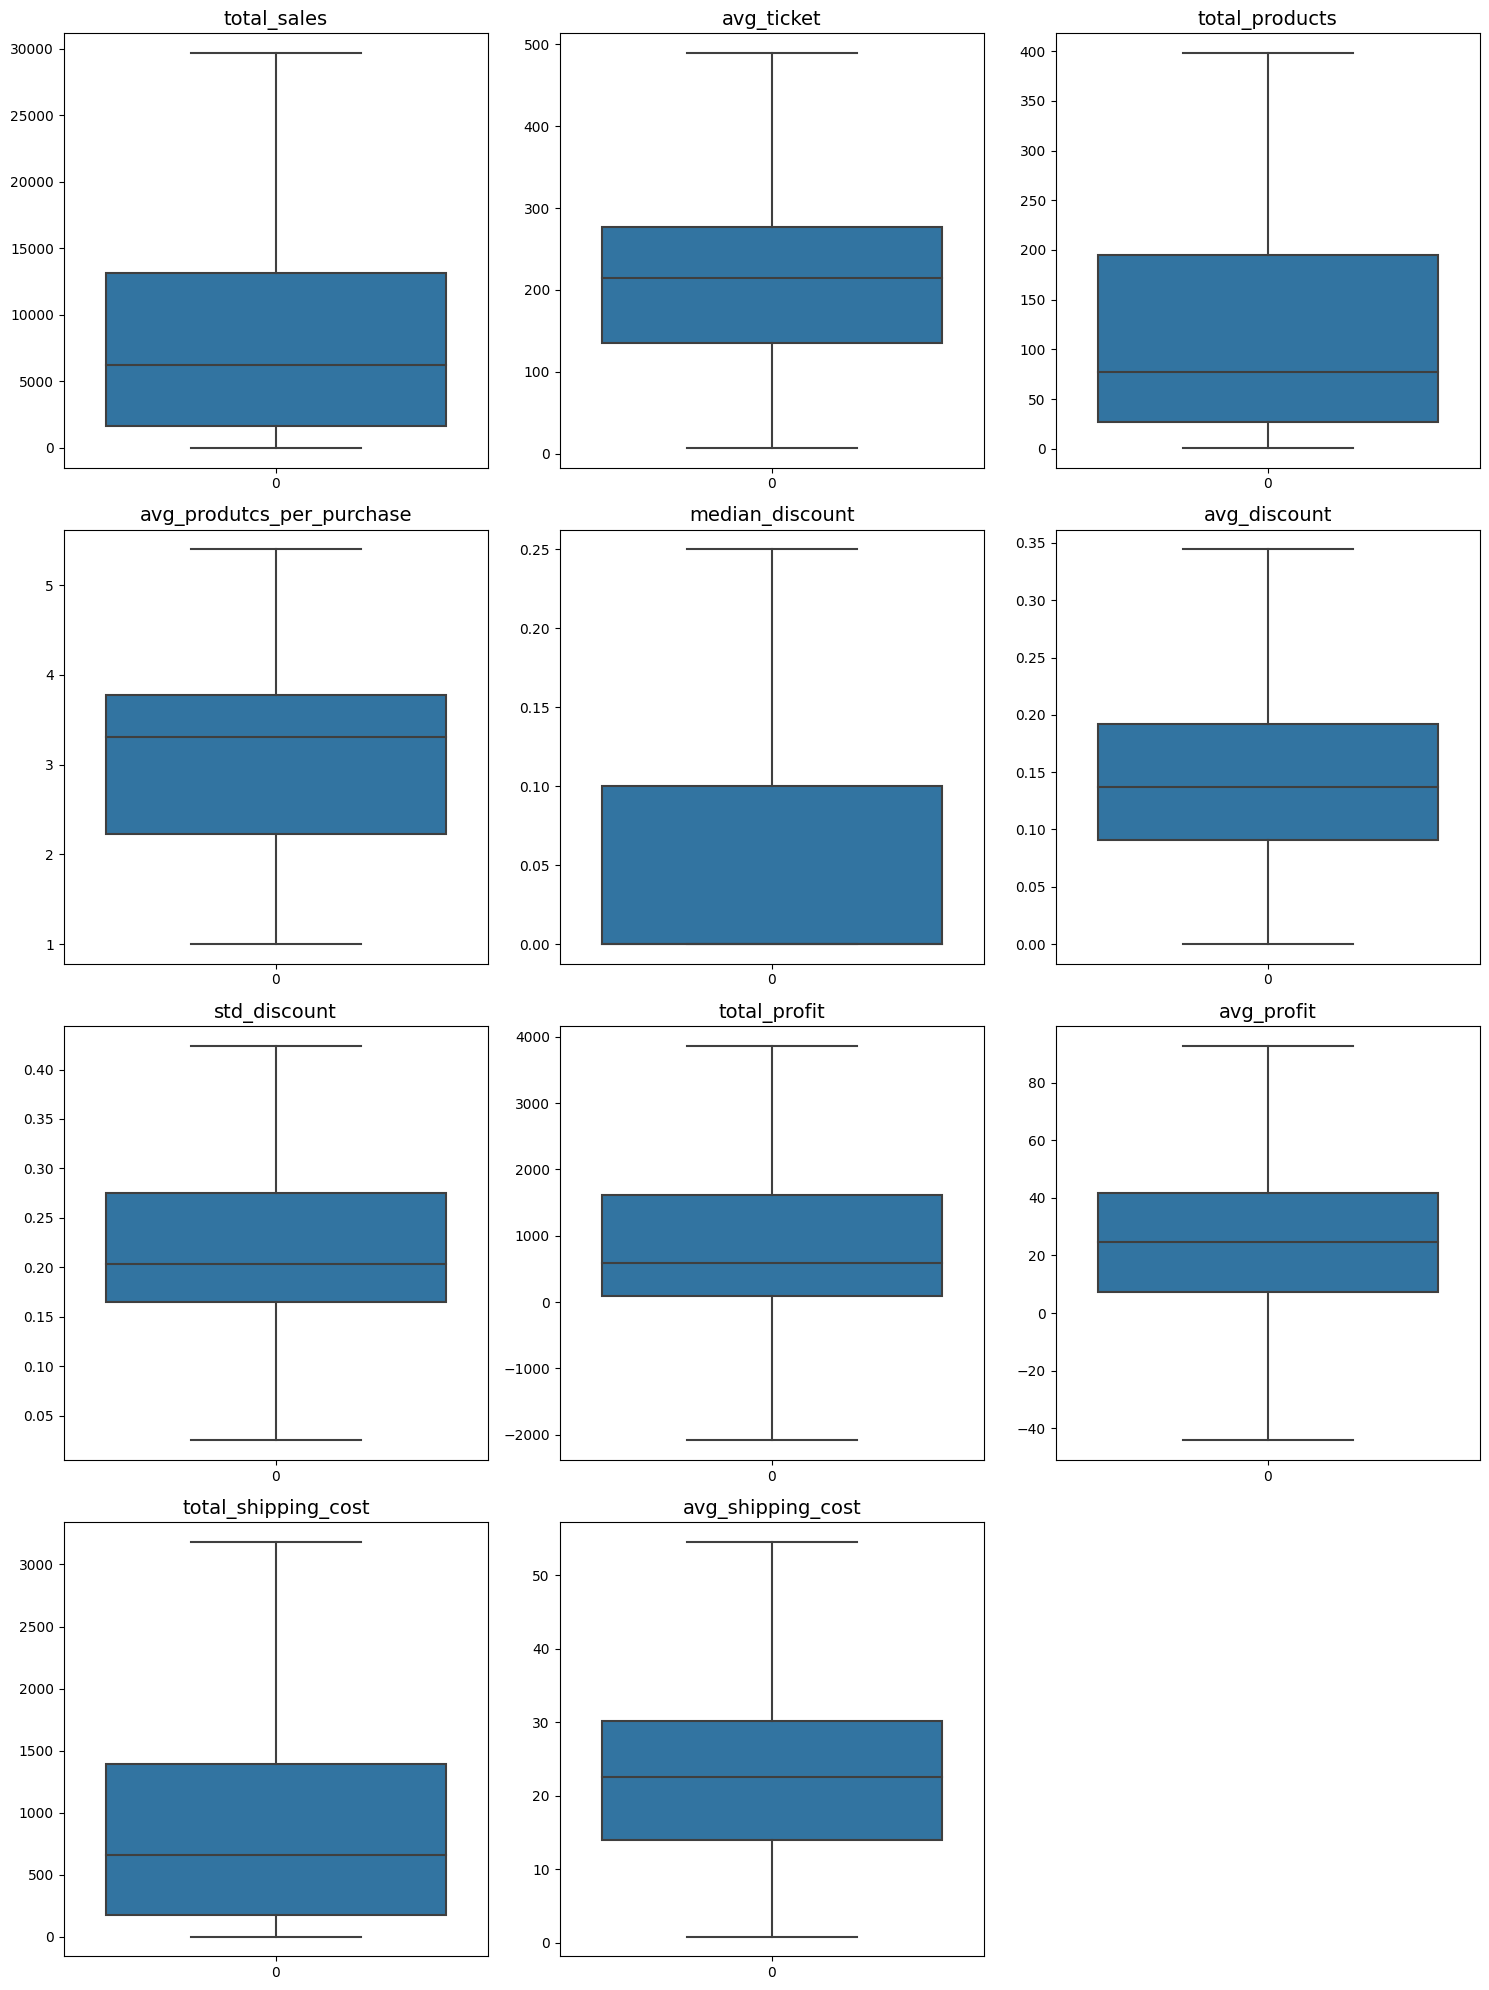

In [36]:
# Set up the plotting area for individual subplots
num_columns = 3
num_features = len(features)
num_rows = (num_features + num_columns - 1) // num_columns

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.boxplot(data=df_customer_abt[feature], showfliers=False, orient='v')
    plt.title(f"{feature}", fontsize=14)

plt.tight_layout()
plt.show()

#### Bar Plots

No PLot because of Unique Values for 'Customer ID' = 1590


C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

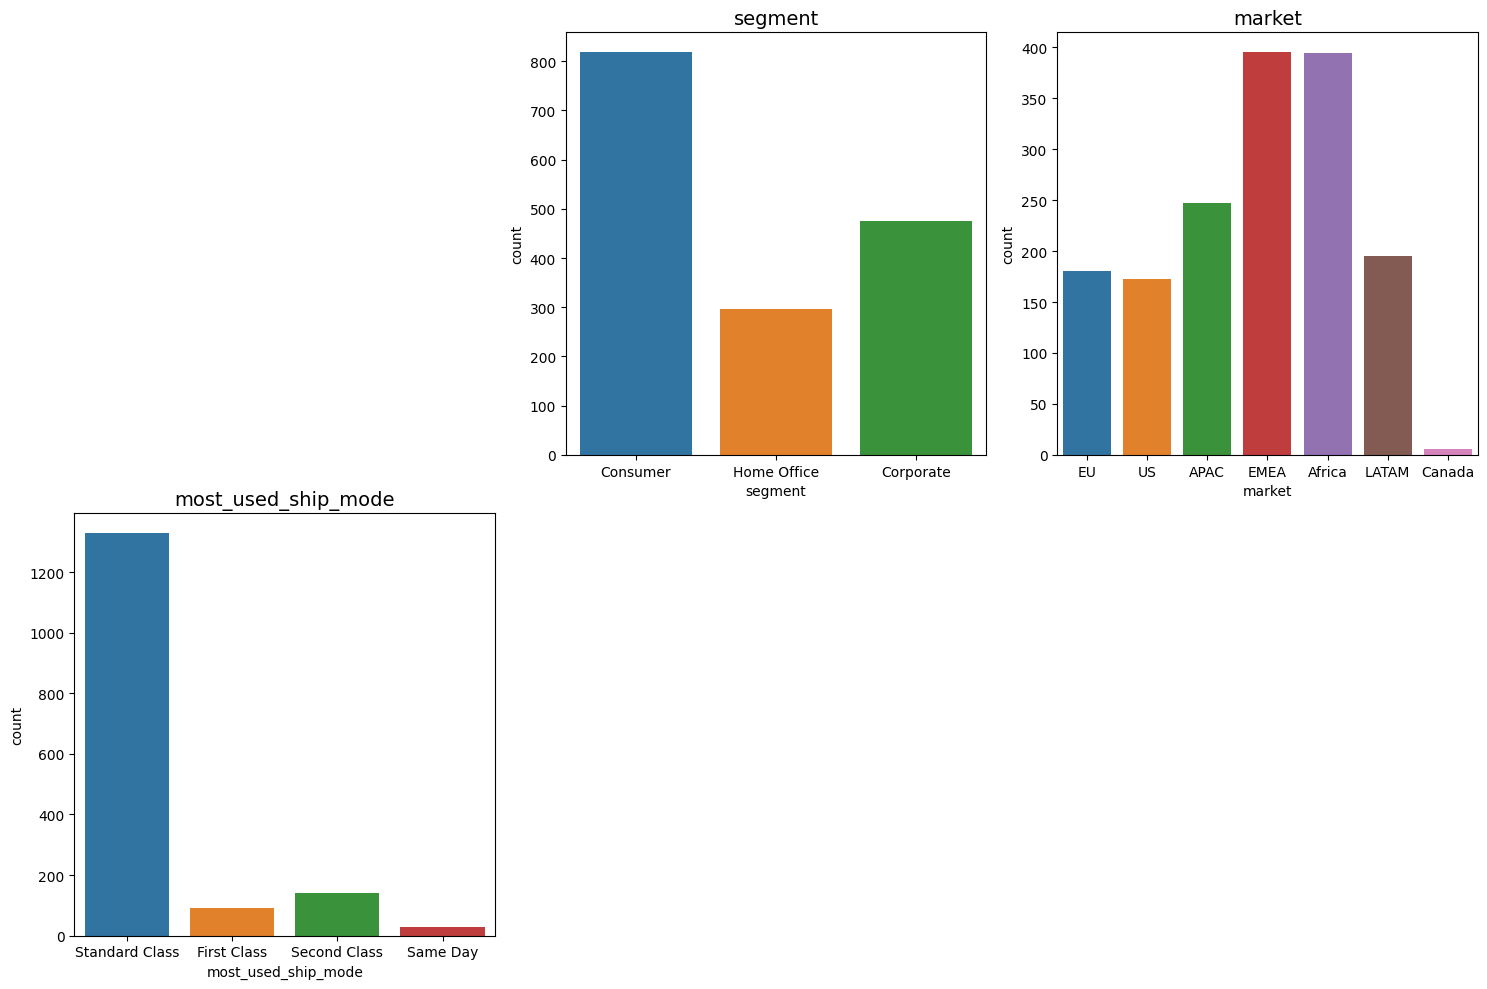

In [44]:
# Set up the plotting area for individual subplots
num_columns = 3
num_categories = len(categories)  # Use categories instead of features
num_rows = (num_categories + num_columns - 1) // num_columns

# Set the figure size
plt.figure(figsize=(15, num_rows * 5))

# Loop through each category and create a count plot
for i, category in enumerate(categories):
    if df_customer_abt[category].nunique() <= 10:
        plt.subplot(num_rows, num_columns, i + 1)
        sns.countplot(data=df_customer_abt, x=category)
        plt.title(f"{category}", fontsize=14)
    else:
        print(f"No PLot because of Unique Values for '{category}' = {df_customer_abt[category].nunique()}")
plt.tight_layout()
plt.show()

## Bivariate Analysis

Identify potential patterns, correlations, or dependencies between variables.   
Is there a natural grouping between multiple variables?

        "You are trying to see the clusters before they are formed"

        Clusters Centers: if centroids are identified K-means might be a good choice.
        Cluster Spread: evaluate spread/dispersion so that DBScan might be of use.

Each Cluster should form a distinct group with minimal overlap. Points within the same cluster should be close together.

        If clusters overlap significantly, you may need to reconsider your feature selection, normalization or clustering algorithm.


If variables show strong correlations, you might decide to remove one of them to reduce multicollinearity.


#### Scatter Plots

#### Pair Plots

In [ ]:
"Just Like The Previous Section"
# sns.pairplot(df_customer_abt[features], diag_kind='kde', plot_kws={'alpha': 0.5})   

#### Box Plots by Category

If significant differences are observed betwee categories, you might decide to include the category in your model.

### Multivariate Analysis

#### Correlation Heatmap

#### 3D Scatter Plot

### Data Distribution and Density

#### Denity Plots (KDE)

#### Hexbin Plots

### Summary and Insights